In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Mallick, Satyaki (1410881)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I found this particular choice of nodes to give efficient results. Having 1500 nodes in the first dense layer gives a pyramid structure with the number of nodes almost halving in each of the dense layers. Also softmax is the choice of activation function for a non binary model output. Moreover I used Stochastic Gradient Descent because that seemed to perform much better than RMSProp which is most commonly used in the lectures.  (length: 432)



Max val score: 80.63%


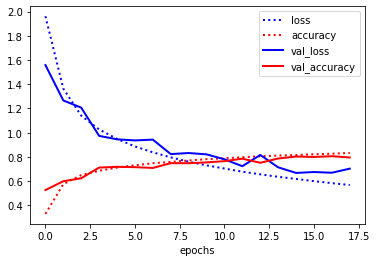

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1500)              4609500   
_________________________________________________________________
dense_5 (Dense)              (None, 500)               750500    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5010      
Total params: 5,365,010
Trainable params: 5,365,010
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
  model = models.Sequential()
  model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
  model.add(layers.Dense(1500, activation='relu'))
  model.add(layers.Dense(500, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model



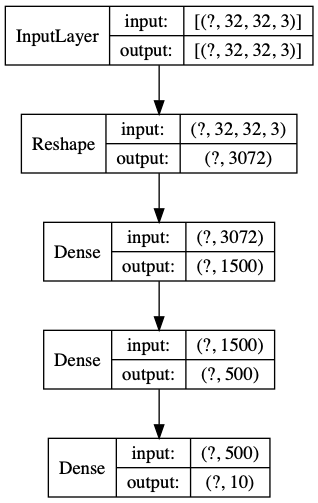

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

I reshaped the input to have 1024 nodes because the input shape is now 32x32x1 instead of 32*32*3 as the image is now grey-scale instead of RGB. The rest of the model is same as the previous Q. But as observed, preprocessing did not give any significant improvement. Rather accuracy is slightly lower than what it was before pre-processing.  (length: 342)



Max val score: 80.47%


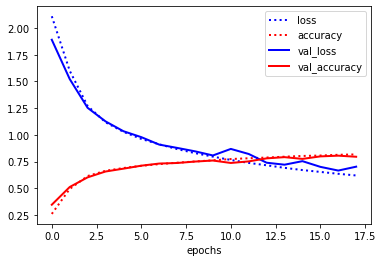

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1500)              1537500   
_________________________________________________________________
dense_8 (Dense)              (None, 500)               750500    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5010      
Total params: 2,293,010
Trainable params: 2,293,010
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_2():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model.add(layers.Dense(1500, activation='relu'))
  model.add(layers.Dense(500, activation='relu'))
  model.add(layers.Dens

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

Here I am using a learning rate of 0.02 for SGD. I am also using kernel regularization for both the dense layers. I have also reduced the batch size to 16 from 32. This gives a small amount of imrpovement, 82% compared to 80% in the previous model. I feel a higher learning rate means the model is less sensitive to local minima and gets nearer to the global minima quickly. Also, the regularizers are applying penalty to the miss-classifications and thus accentuating the nodes which are performing better. Hence, we see a better result.  (length: 540)



Max val score: 82.05%


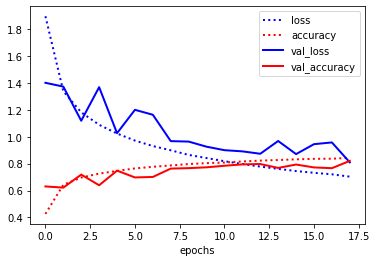

def build_model_1_3():
  sgd = optimizers.SGD(0.02)
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model.add(layers.Dense(1500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I tried this with more 3 dense layers, adding regularization in each layer and adding dropouts at the end of each convolutional layers. Such kind of complicated model failed to give any better result than the much simpler one presented here. Infact having 3 dense layers and 5 convolutional layers actually reduced the accuracy. I managed to get the highest accuracy with the current setting of 3 convolutional layers with max pooling after each of them, a dropout at the end of them, and then adding dense layers with 500 and then 10 nodes. Having a dropout reduced overfitting that was occuring previously. The highest accuracy I could come up with is 91.3%.  (length: 662)



Max val score: 91.29%


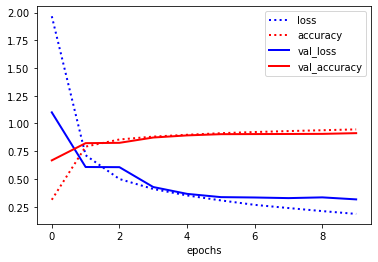

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)            

def build_model_2_1():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                     activation='relu',
                     input_shape=(32,32,1)))
  model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
  model.add(Conv2D(128, (3, 3), name='conv2d_35', activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(250, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer=optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
  return model



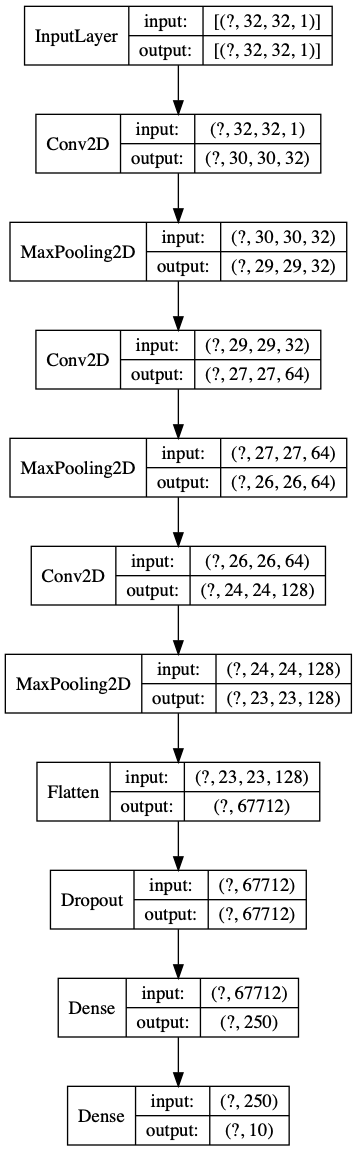

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

I augmented the data with a horizontal flip, width shift and height shift. But as seen below, augmenting the data does not give better results. Rather accuracy decreases a bit. Moreover adding rotation, shear and zoom further reduces the accuracy of the model. My conclusion is because the images are already quite small, image generation does not give any significant improvement. Less pixel mean less information and we lose details with augmenting.  (length: 453)



Max val score: 88.26%


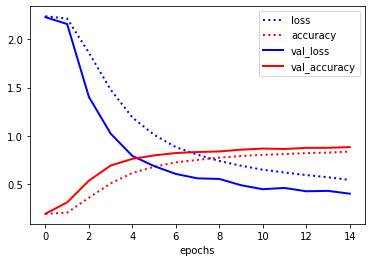


train_datagen = ImageDataGenerator(
   # rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
   # shear_range=0.1,
  #  zoom_range=0.1,
    horizontal_flip=True,)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

The labelling is a bit different in the y_test array. Index 0 is labelled as 1 and so on where index 9 is labelled as 0. From confusion matrix we notice that 3 and 5, and 1 and 7 are most commonly misclassified. Common misclassification of digit 5 is shown below. As can be seen, some images are hard to distinguish even with human eye. Images which have 2 digits are also tough to classify, because the original labelling might be one of the digits whereas the model detects the other digit. Splitting the two digit images to single digit images will solve this problem. As seen in the results, images where the color of the printed digit is close to that of the background is also commonly misclassified.  (length: 708)

Test score: 0.88%


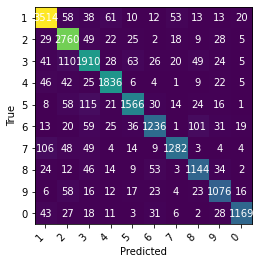

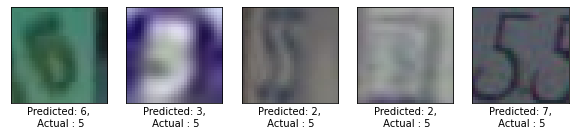

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

As seen in activation layer 0, the filters detect the edges in the image 8. As we go deeper to activation layer 3, we see that there the model can make out the presence of 2 circles in the images and as we go further down to activation layer 5, we see that the filters finds out curves in the image. We can say that the model actually learns the presence of circles and curves in the images which help in detention of images like 8 or 9 or 6 (length: 442)



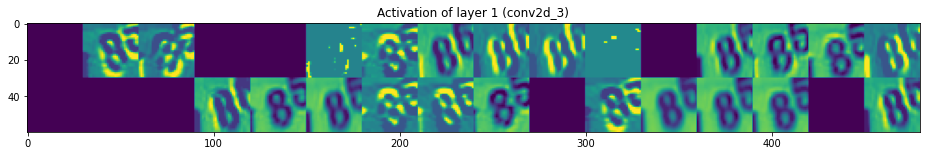

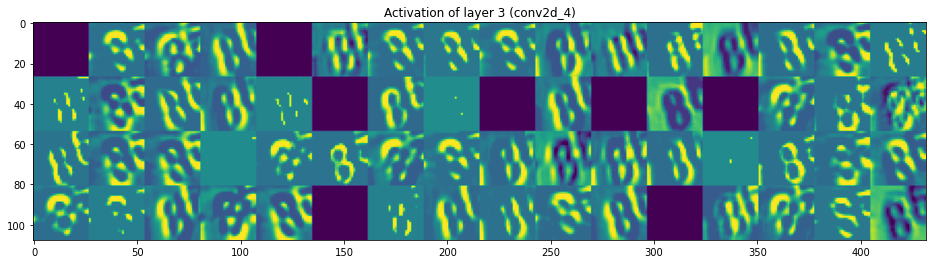

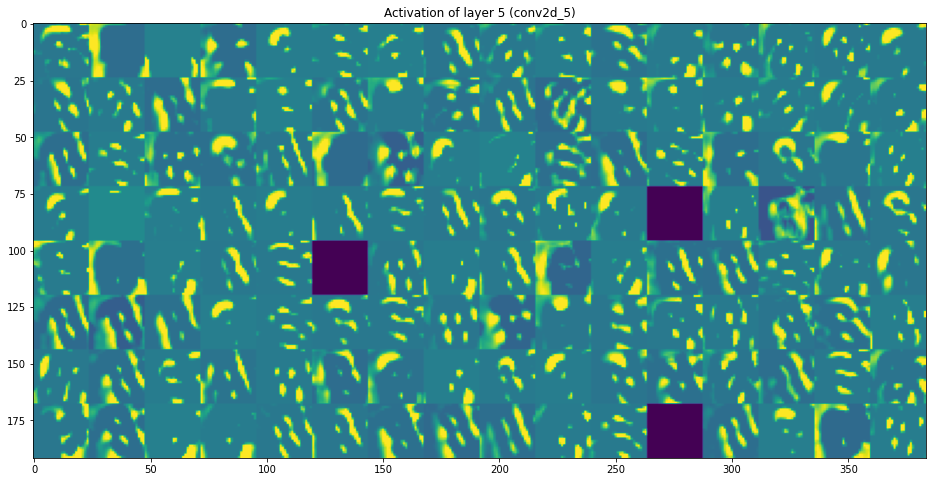

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

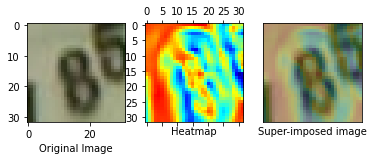

def plot_activation_map():

  img_tensor = X_test_p[0]
  model = load_model_from_file(base_dir, "model_2_2")

  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_op = model.output[:]
  
  last_conv_layer = model.get_layer(index=4)
  grads = K.gradients(img_op, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  return heatmap



In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Having all layers frozen gives really poor results. Accuracy is around 50%. The most obvious reason for this is the vgg16 model is too customised for the data it is trained on. When I remove the last set of convulational layers, Block 5, the accuracy improves a lot, reaches 82%. I happen to notice an even better accuracy when I don't have the last 2 convolutional layers blocks, namely block 5 and 4. In such setting, the accuracy increases even further to 87%. (I added the function without the model because the model exceeds 100 MB.)  (length: 540)



Max val score: 57.41%


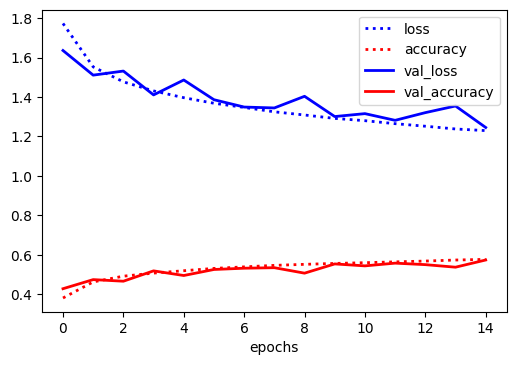

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_43 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_120 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_121 (Dense)            (None, 10)                2570      
Total params: 15,111,242
Trainable params: 396,554
Non-trainable params: 14,714,688
_________________________________________________________________
None


def build_model_4_1():
  conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(32, 32, 3))
  

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  conv_base.trainable = False
  model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model



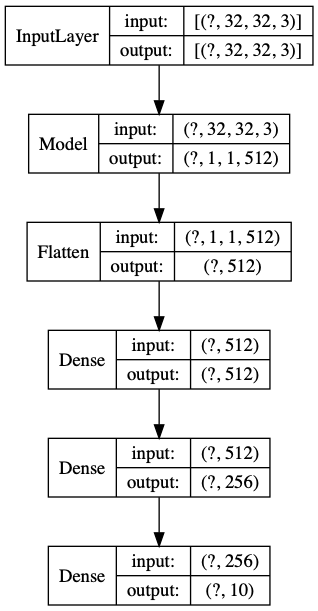

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I create the ebeddings using VGG16(without dense layers). Then I use this embeddings on my scikit_learn pipeline to get predictions and get an accuracy score. I also transform y_test to a 1D array to make it work better on RandomForest. I tried using AdaBoost and DecisionTrees but their accuracy is much lower, The best accuracy is 48% using Random Forest. SVC takes humongous time to run and my Colab runtime timesout before it ends.  (length: 437)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf', RandomForestClassifier())])
def store_embeddings():
  model_4_1 = load_model_from_file(base_dir, "model_4_1")
  intermediate_model = models.Model(inputs=model_4_1.input, outputs=model_4_1.layers[1].output)
  
  outp_Xtrain = intermediate_model.predict(X_train)
  outp_Xtest = intermediate_model.predict(X_test)

  store_embedding(outp_Xtrain, 'X_train_embedding')
  store_embedding(outp_Xtest, 'X_test_embedding')

  return

def evaluation_4_2(X_tr

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 12.40 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
